# Learning Rate

## LEarning rate finder

In [24]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset
from sklearn import datasets
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

In [4]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform = None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)
        return X, y

class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.flatten = nn.Flatten(1, -1)
        self.l1 = nn.Linear(num_in, num_hidden) # 隠れ層(第1層)を定義
        self.l2 = nn.Linear(num_hidden, num_out) # 隠れ層(第2層)を定義

    def forward(self, x):
        x = self.flatten(x)
        # z1 = self.l1(x) 
        # a1 = F.relu(z1)
        # z2 = self.l2(a1)
        x = self.l2(F.relu(self.l1(x)))
        return x

def learn(model, train_loader, val_loader, opt, loss_func, num_epoch, early_stopping = None, save_path = None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []
    # early_stopping_counter
    no_improve = 0
    

    best_val_loss = float('inf')
    # モデル学習
    for epoch in range(num_epoch):
        running_loss = 0
        running_val_loss = 0
        running_val_accuracy = 0
        
        for train_batch, data in enumerate(train_loader):
    
            X, y = data
            opt.zero_grad() # 勾配初期化
            # forward
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
    
            # backward
            loss.backward()
            opt.step() # パラメータ更新
            
    
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim = -1) == y_val) / y_val.shape[0]
                running_val_accuracy += val_accuracy.item()
    
        train_losses.append(running_loss / (train_batch + 1))
        val_losses.append(running_val_loss / (val_batch + 1))
        val_accuracies.append(running_val_accuracy / (val_batch + 1))
        print(f'epoch:{epoch}, train error:{train_losses[-1]}, val_losses:{val_losses[-1]}, val_accuracy:{val_accuracies[-1]}')
        if val_losses[-1] < best_val_loss:
            no_improve = 0
            best_val_loss = val_losses[-1]
            best_model = model
        else:
            no_improve += 1
        if early_stopping and no_improve >= early_stopping:
            print("stop training because val loss don't improve anymore")
            if save_path:
                torch.save({'model_parameter' : best_model.state_dict(), 'opt_parameter' : opt.state_dict(), 'val_loss' : best_val_loss}, save_path)
            break

    if save_path:
        torch.save({'model_parameter' : best_model.state_dict(), 'opt_parameter' : opt.state_dict(), 'val_loss' : best_val_loss}, save_path)
    return train_losses, val_losses, val_accuracies

In [20]:
# データ準備
dataset = datasets.load_digits()
data = dataset['data']
target = dataset['target']
images = dataset['images']
images = images * (255. / 16.) # 0~16 -> 0~255
images = images.astype(np.uint8)
# 学習データと検証データの作成
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size = 0.2, random_state = 0)
# DatasetとDataLoaderの作成
batch_size = 10
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])
train_dataset = MyDataset(X_train, y_train, transform = transform)
val_dataset = MyDataset(X_val, y_val, transform = transform)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size = batch_size, num_workers = 2)
# モデルの初期化
model = MLP(64, 30, 10)
# optimizerの定義
learning_rate = 0.03
opt = optim.SGD(model.parameters(), lr = learning_rate)

# train_losses, val_losses, val_accuracies = learn(model, train_loader, val_loader, opt = opt, loss_func = F.cross_entropy, num_epoch = 1000, early_stopping=5, save_path = 'checkpoint')

In [23]:
opt.param_groups

[{'params': [Parameter containing:
   tensor([[ 0.5466,  0.7565,  0.3503,  ..., -0.2030,  0.5995,  0.6635],
           [ 0.0782,  0.0431,  0.1199,  ...,  0.2469,  0.1201,  0.1856],
           [ 0.0323,  0.0892, -0.0286,  ...,  0.0333, -0.1128,  0.1176],
           ...,
           [ 0.0754,  0.0113, -0.0255,  ...,  0.0175,  0.1335,  0.0615],
           [ 0.3602,  0.3386, -0.0361,  ...,  0.3106,  0.3233,  0.2860],
           [ 0.1959,  0.1084,  0.1510,  ...,  0.1197,  0.2127,  0.2505]],
          requires_grad=True),
   Parameter containing:
   tensor([-0.6520,  0.0640,  0.0294, -0.1168, -0.1918, -0.0448, -0.1227, -0.2190,
           -0.0514, -0.0634, -0.1905, -0.0622, -0.0489,  0.0356, -0.1606, -0.2922,
           -0.3593,  0.0377, -0.2403, -1.2062, -0.0170, -0.3597, -0.1383, -2.0753,
            0.0580, -0.3910, -0.2865, -0.0616, -0.3941, -0.1797],
          requires_grad=True),
   Parameter containing:
   tensor([[-7.4221e-01, -2.2722e-01,  3.8987e-02,  3.5732e-01,  8.6752e-02,
      

In [21]:
def lr_finder(model, train_loader, loss_func, lr_multiplier=1.2):

    lr = 1e-8
    max_lr = 10
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    losses = []
    lrs = []

    for train_batch, data in enumerate(train_loader):
        X, y = data
        
        opt.zero_grad()
        # forward
        preds = model(X)
        loss = loss_func(preds, y)
        losses.append(loss.item())
        lrs.append(lr)

        # backward
        loss.backward()
        opt.step()

        lr *= lr_multiplier

        for param_group in opt.param_groups:
            param_group['lr'] = lr
        if lr > max_lr:
            break

    return lrs, losses

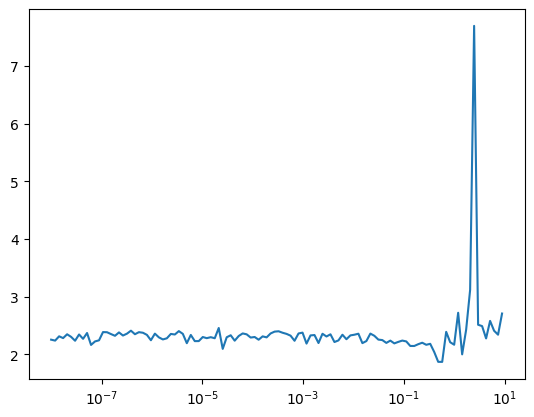

In [22]:
lrs, losses = lr_finder(model, train_loader, F.cross_entropy, lr_multiplier=1.2)
plt.plot(lrs, losses)
plt.xscale('log')

## Learning Rate Scheduler

In [30]:
# StepLR
# モデルの初期化
model = MLP(64, 30, 10)
# optimizerの定義
learning_rate = 0.1
opt = optim.SGD(model.parameters(), lr = learning_rate)

scheduler = StepLR(opt, step_size = 30, gamma = 0.1)
for param_group in opt.param_groups:
    print(param_group['lr'])
for epoch in range(30):
    scheduler.step()
for param_group in opt.param_groups:
    print(param_group['lr'])

0.1
0.010000000000000002


In [31]:
# CosineAnnealingLR
# モデルの初期化
model = MLP(64, 30, 10)
# optimizerの定義
learning_rate = 0.1
opt = optim.SGD(model.parameters(), lr = learning_rate)

scheduler = CosineAnnealingLR(opt, T_max = 50)
lrs = []
for epoch in range(150):
    lrs.append(opt.param_groups[0]['lr'])
    scheduler.step()

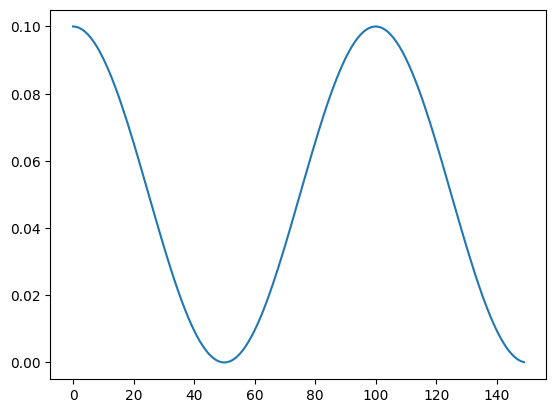

In [33]:
plt.plot(lrs)

In [34]:
def learn(model, train_loader, val_loader, opt, loss_func, num_epoch, early_stopping = None, save_path = None, scheduler = None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []
    # early_stopping_counter
    no_improve = 0
    

    best_val_loss = float('inf')
    # モデル学習
    for epoch in range(num_epoch):
        running_loss = 0
        running_val_loss = 0
        running_val_accuracy = 0
        
        for train_batch, data in enumerate(train_loader):
    
            X, y = data
            opt.zero_grad() # 勾配初期化
            # forward
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
    
            # backward
            loss.backward()
            opt.step() # パラメータ更新
            
    
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim = -1) == y_val) / y_val.shape[0]
                running_val_accuracy += val_accuracy.item()
    
        train_losses.append(running_loss / (train_batch + 1))
        val_losses.append(running_val_loss / (val_batch + 1))
        val_accuracies.append(running_val_accuracy / (val_batch + 1))
        print(f'epoch:{epoch}, train error:{train_losses[-1]}, val_losses:{val_losses[-1]}, val_accuracy:{val_accuracies[-1]}')
        if val_losses[-1] < best_val_loss:
            no_improve = 0
            best_val_loss = val_losses[-1]
            best_model = model
        else:
            no_improve += 1
        if early_stopping and no_improve >= early_stopping:
            print("stop training because val loss don't improve anymore")
            if save_path:
                torch.save({'model_parameter' : best_model.state_dict(), 'opt_parameter' : opt.state_dict(), 'val_loss' : best_val_loss}, save_path)
            break
        if scheduler:
            scheduler.step()

    if save_path:
        torch.save({'model_parameter' : best_model.state_dict(), 'opt_parameter' : opt.state_dict(), 'val_loss' : best_val_loss}, save_path)
    return train_losses, val_losses, val_accuracies

In [35]:
model = MLP(64, 30, 10)
# optimizerの定義
learning_rate = 0.1
opt = optim.SGD(model.parameters(), lr = learning_rate)

scheduler = StepLR(opt, step_size = 30, gamma = 0.1)
learn(model, train_loader, val_loader, opt, F.cross_entropy, 100, scheduler = scheduler)

epoch:0, train error:1.0486768979786172, val_losses:0.35854486251870793, val_accuracy:0.9416666610373391
epoch:1, train error:0.25467274700187975, val_losses:0.22101124608889222, val_accuracy:0.9499999913904402
epoch:2, train error:0.1532225080170772, val_losses:0.17859108451132974, val_accuracy:0.9694444388151169
epoch:3, train error:0.12377014080347079, val_losses:0.1841902134474367, val_accuracy:0.9333333240614997
epoch:4, train error:0.09507730119447741, val_losses:0.11673201405857173, val_accuracy:0.9666666603750653
epoch:5, train error:0.07589160382243183, val_losses:0.13620436483890647, val_accuracy:0.9638888802793291
epoch:6, train error:0.06556847347302311, val_losses:0.11431206207230894, val_accuracy:0.9722222172551684
epoch:7, train error:0.053114784917852376, val_losses:0.18102435288407528, val_accuracy:0.9305555489328172
epoch:8, train error:0.046026225754354125, val_losses:0.1122608753762001, val_accuracy:0.9722222172551684
epoch:9, train error:0.04126583087620222, val_lo

([1.0486768979786172,
  0.25467274700187975,
  0.1532225080170772,
  0.12377014080347079,
  0.09507730119447741,
  0.07589160382243183,
  0.06556847347302311,
  0.053114784917852376,
  0.046026225754354125,
  0.04126583087620222,
  0.03571712455515,
  0.030971728878082812,
  0.02519558344768787,
  0.02401340439488801,
  0.020776665202801168,
  0.019267922141403285,
  0.01684821480113088,
  0.015672707269813044,
  0.014354760626904155,
  0.013897211745845399,
  0.013503251615677274,
  0.01201122615505786,
  0.012712083191116916,
  0.01091888793108511,
  0.009986058184242412,
  0.008095616998010277,
  0.00930464790288473,
  0.007782064539898986,
  0.007527065980765555,
  0.007472808797097564,
  0.0060771509562174385,
  0.005877681561691538,
  0.005831264278034117,
  0.005770375913572125,
  0.005810947867757932,
  0.005722237007477007,
  0.0057056625090707615,
  0.005675472815280753,
  0.005670870379491235,
  0.005621454531920891,
  0.005625995844992657,
  0.005557250086894783,
  0.005552

In [36]:
opt.param_groups

[{'params': [Parameter containing:
   tensor([[-0.1231,  0.1084,  0.0903,  ..., -0.1925, -0.1790,  0.0548],
           [ 0.0218,  0.0749, -0.1116,  ...,  0.1093, -0.0923,  0.0406],
           [-0.1331, -0.2009,  0.2194,  ..., -0.3107, -0.3127, -0.0510],
           ...,
           [-0.0808,  0.1567,  0.0757,  ...,  0.0542, -0.1208, -0.2510],
           [-0.0077, -0.1628,  0.0147,  ...,  0.1788,  0.2027,  0.1099],
           [ 0.1182, -0.0873,  0.0510,  ...,  0.1379,  0.0937,  0.0808]],
          requires_grad=True),
   Parameter containing:
   tensor([-0.0096, -0.0460,  0.1612, -0.0037, -0.0118,  0.1059,  0.1016,  0.1976,
           -0.0373, -0.0764, -0.0083,  0.0686, -0.0039,  0.0329,  0.0851,  0.0356,
            0.0395,  0.0365,  0.1564,  0.0138,  0.0019, -0.0468,  0.0439,  0.0184,
            0.1172,  0.1316, -0.0643,  0.0706,  0.1093, -0.0899],
          requires_grad=True),
   Parameter containing:
   tensor([[-0.4029,  0.1400,  0.4518,  0.4178, -0.4440, -0.5956, -0.2029,  1.2656,